# QLDPC Hierarchical Contraction

分层收缩，针对QLDPC，我们需要实现更加精准、独特的收缩方法，我们将其称为分层收缩。

我们的收缩分为两层：
1. 第一层：我们先对所有翻转的检测器的相关超边进行收缩，我们尽可能保证该收缩过程是较为精准的，可能使用node_topk或者k很高的hyperedge_topk。
2. 第二层：我们对其他没有收缩的超边进行收缩，我们这部分，我们可以尽可能快速的收缩，可能使用hyperedge_topk，其中k可以取的很小。

这样，我们希望能够得到一个尽可能准确的结果。


### 子超图获取

In [ ]:
import stim
nkd_72_12_6_r1 = "../data/external/eamld_experiment_data/paper_experiment_bb_codes/Z/nkd_72_12_6_r1/circuit_noisy_si1000_p10.stim"
circuit_noisy_r1 = stim.Circuit.from_file(nkd_72_12_6_r1)
dem_r1 = circuit_noisy_r1.detector_error_model(decompose_errors=False, flatten_loops= True)

In [ ]:
from eamld.contraction_strategy.dem_to_hypergraph import DetectorErrorModelHypergraph
hypergraph = DetectorErrorModelHypergraph(detector_error_model=dem_r1, have_logical_observable= True)
nodes = hypergraph.get_nodes()
hyperedges = hypergraph.get_hyperedges()
weights = hypergraph.get_weights()

In [3]:
flipped_detector_set = set(["D0", "D3"])

In [4]:
sub_hypergraph = hypergraph.get_sub_hypergraph(nodes = flipped_detector_set)

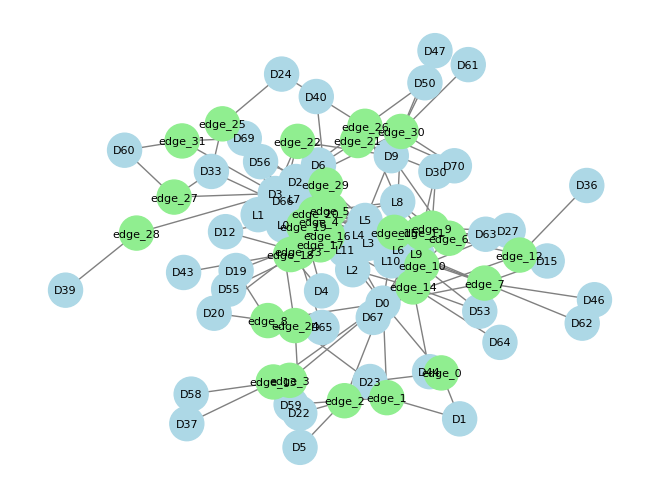

In [5]:
sub_hypergraph.draw_bipartite_graph()

### 将子超图转化为连通图

In [ ]:
from eamld.contraction_strategy.hypergraph_to_connectivity import ConnectivityGraph

sub_connectivity_graph = ConnectivityGraph()
sub_connectivity_graph.hypergraph_to_connectivity_graph(sub_hypergraph, have_logical_observable = False)

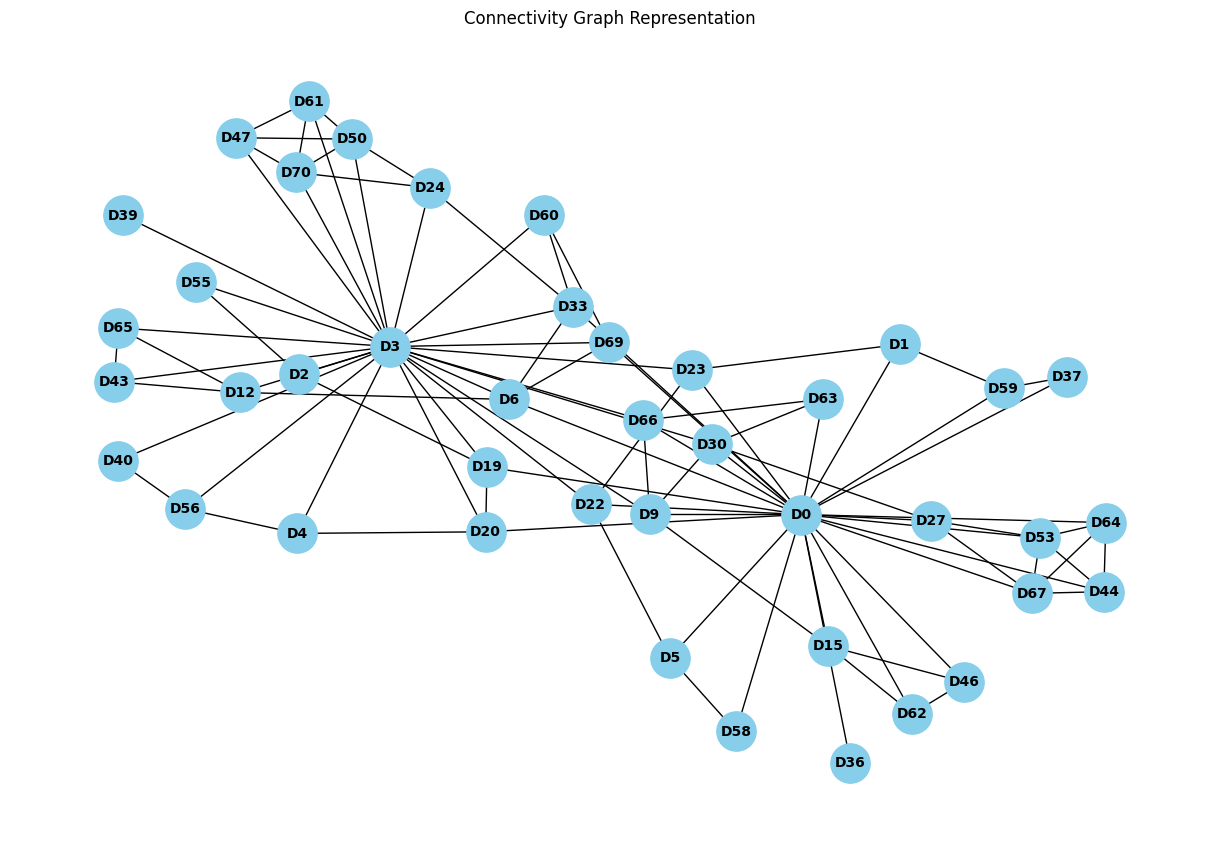

In [7]:
sub_connectivity_graph.draw()

### 根据连通图，得到计算的顺序

In [ ]:
from eamld.contraction_strategy.mld_order_finder import GreedyMLDOrderFinder, ParallelGreedyMLDOrderFinder

order_finder = GreedyMLDOrderFinder(sub_connectivity_graph)
order = order_finder.find_order()
print(f"order: {order}")
print(f"max_dim:{order_finder.max_prob_dist_dimension}")
print(f"max_dim count:{order_finder.max_prob_dist_dimension_count}")
print(f"max_dim nodes:{order_finder.max_contracted_nodes}")

order: ['D36', 'D0', 'D1', 'D15', 'D27', 'D37', 'D44', 'D46', 'D5', 'D53', 'D58', 'D59', 'D62', 'D63', 'D64', 'D67', 'D22', 'D23', 'D30', 'D66', 'D9', 'D19', 'D2', 'D55', 'D20', 'D4', 'D56', 'D40', 'D6', 'D69', 'D60', 'D33', 'D12', 'D43', 'D65', 'D24', 'D50', 'D47', 'D61', 'D70', 'D3', 'D39']
max_dim:24
max_dim count:1
max_dim nodes:['D0']


我们只需要flipped_detectors的顺序即可。

In [9]:
sub_order = [x for x in order if x in flipped_detector_set]

In [10]:
sub_order

['D0', 'D3']

### 直接进行超图的收缩

为了最小的收缩成本，我们可以直接按照order得到的收缩顺序进行收缩。

In [ ]:
from typing import  Dict, Union, List
import numpy as np
from eamld.contraction_executor import build_hyperedge_contraction_caches

hypergraph = DetectorErrorModelHypergraph(detector_error_model=dem_r1, have_logical_observable= True)
sub_hypergraph = hypergraph.get_sub_hypergraph(nodes = flipped_detector_set)

original_dict = sub_hypergraph.get_hyperedges_weights_dict()
contractable_hyperedges_weights_dict: dict[str, float] = {",".join(key): float(value) for key, value in original_dict.items()}

# 节点等于子超图的节点数
num_detectors : int = dem_r1.num_detectors
# 观测器，一定是超图的观测器
num_observables : int = dem_r1.num_observables

order: list[str] = order
sliced_hyperedges: list[str] = []
accuracy: str = "float64"

hyperedge_cache, relevant_hyperedge_cache = build_hyperedge_contraction_caches(contractable_hyperedges_weights_dict, order)

构建收缩器

In [ ]:
from eamld.contraction_executor import HierarchicalApproximateContractionExecutorQldpc
# approximatestrategy = "node_threshold"
# approximate_param = 10**-12
approximatestrategy = "no_no"
approximate_param = None
contractor = HierarchicalApproximateContractionExecutorQldpc(
    num_detectors,
    num_observables,
    order,
    sliced_hyperedges,
    contractable_hyperedges_weights_dict,
    accuracy,
    approximatestrategy,
    approximate_param,
    hyperedge_cache,
    relevant_hyperedge_cache,
    hypergraph
)

解码分析

In [13]:
import time
import numpy as np

# syndrome_len = sub_hypergraph.get_nodes_number()

np.random.seed(100)
# random_syndrome = np.random.choice([False, True], size=dem_r1.num_detectors)
# syndrome = np.array([False] * (num_detectors))
# syndrome = np.array([True]+ [False] + [False] + [True] + [False] * (num_detectors-4))
syndrome = np.array([False] * (num_detectors))
# print("random_syndrome", random_syndrome)
start = time.time()
prob_dist = contractor.mld_contraction_no_slicing(syndrome)
print(f"end contraction: {time.time() - start}")
print(f"output prob_dist:", prob_dist)

# # Validate and return the prediction
# prediction, prob_correct_correction = contractor.validate_logical_operator(prob_dist)
# print(f"prediction:", prediction)

end contraction: 6.29425048828125e-05
output prob_dist: {'000000000000000000000000000000000000000000000000000000000000000000000000000000000000': np.float64(1.0)}


In [14]:
set([f"D{idx}" for idx in np.where(syndrome)[0]])

set()

# 调用EAMLD中的接口进行解码

### EAMLD

In [ ]:
import eamld
from eamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark

# nkd = [72, 12, 6]
nkd = [90, 8, 10]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 100

related_path = "../data/external/eamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

decoder = eamld.EAMLD(detector_error_model=dem,
                            order_method='greedy',
                            slice_method='no_slice',
                            use_approx = True,
                            approximatestrategy = approximatestrategy,
                            approximate_param = approximate_param,
                            contraction_code = "qldpc-hierarchical-first",
                            accuracy = "float64")

In [2]:
benchmark = LogicalErrorRateBenchmark(
    decoder_function=decoder,
    d=nkd[2],
    nkd=nkd,
    r=r,
    p=p,
    noise_model=noise_model,
    error_type=error_type,
    num_runs=1,
    data_path=related_path,
    code_name="qldpc code"
)
# 运行基准测试并获取结果
logical_error_rate = benchmark.run()[0]

2025-04-09 15:18:15,119 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 15:18:15,120 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-09 15:18:15,808 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.6874532699584961
2025-04-09 15:32:39,491 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 159/1000000 mistakes, num_unique_shots is 265987, error rate: 0.000159
2025-04-09 15:32:39,496 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 864.3756 seconds - Error rate: 0.000159
2025-04-09 15:32:39,496 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.000159


只收缩翻转部分：
* 收缩参数400，969/1000000，运行时间259.4257 seconds。

先收缩翻转部分（根据syndrome剪枝），再翻其他部分，根据syndrome进行剪枝：
* 收缩参数400，967/1000000，运行时间1092.0784 s。
似乎效果并不明显，同时来引入的大量的计算时间。


不同的汉明码矩，采用不同的收缩参数：
* 初始收缩参数为：100，633/1000000，692.4448 s。

基于概率大小的剪枝，效果很差。

In [ ]:
# import eamld
# from eamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark

# nkd = [72, 12, 6]
# p = 5
# r=1
# noise_model = "si1000" # v5
# error_type = "Z"
# approximatestrategy = "hyperedge_threshold"
# approximate_param = 10**-10

# related_path = "../data/external/eamld_experiment_data/paper_experiment_bb_codes"
# dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

# decoder = eamld.EAMLD(detector_error_model=dem,
#                             order_method='greedy',
#                             slice_method='no_slice',
#                             use_approx = True,
#                             approximatestrategy = approximatestrategy,
#                             approximate_param = approximate_param,
#                             contraction_code = "qldpc-hierarchical-first",
#                             accuracy = "float64")
# benchmark = LogicalErrorRateBenchmark(
#     decoder_function=decoder,
#     d=nkd[2],
#     nkd=nkd,
#     r=r,
#     p=p,
#     noise_model=noise_model,
#     error_type=error_type,
#     num_runs=1,
#     data_path=related_path,
#     code_name="qldpc code"
# )
# # 运行基准测试并获取结果
# logical_error_rate = benchmark.run()[0]

之前的方法

In [ ]:
# import eamld
# from eamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark

# nkd = [72, 12, 6]
# p = 5
# r=1
# noise_model = "si1000" # v5
# error_type = "Z"
# approximatestrategy = "hyperedge_topk"
# approximate_param = 10

# related_path = "../data/external/eamld_experiment_data/paper_experiment_bb_codes"
# dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

# decoder = eamld.EAMLD(detector_error_model=dem,
#                             order_method='greedy',
#                             slice_method='no_slice',
#                             use_approx = True,
#                             approximatestrategy = approximatestrategy,
#                             approximate_param = approximate_param,
#                             contraction_code = "qldpc",
#                             accuracy = "float64")
# benchmark = LogicalErrorRateBenchmark(
#     decoder_function=decoder,
#     d=nkd[2],
#     nkd=nkd,
#     r=r,
#     p=p,
#     noise_model=noise_model,
#     error_type=error_type,
#     num_runs=1,
#     data_path=related_path,
#     code_name="qldpc code"
# )
# # 运行基准测试并获取结果
# logical_error_rate = benchmark.run()[0]

### BP+OSD

BP+OSD

In [ ]:
import eamld
from eamld.benchmark import generate_qldpc_detector_error_model, LogicalErrorRateBenchmark
from stimbposd import BPOSD

# nkd = [72, 12, 6]
nkd = [90, 8, 10]
p = 10
r=1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 10

related_path = "../data/external/eamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

max_bp_iters = 100
decoder  = BPOSD(dem, max_bp_iters = max_bp_iters)

benchmark = LogicalErrorRateBenchmark(
    decoder_function=decoder,
    d=nkd[2],
    nkd=nkd,
    r=r,
    p=p,
    noise_model=noise_model,
    error_type=error_type,
    num_runs=1,
    data_path=related_path,
    code_name="qldpc code"
)
# 运行基准测试并获取结果
logical_error_rate = benchmark.run()[0]

2025-04-09 15:14:48,751 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Starting benchmarking...
2025-04-09 15:14:48,752 - epmld/benchmark/logical_error_rate_benchmarking - INFO - start preprocessing, syndrome:(1000000, 90)...
2025-04-09 15:14:49,238 - epmld/benchmark/logical_error_rate_benchmarking - INFO - syndrome规模为(1000000, 90) 预处理时间为：0.48627614974975586
2025-04-09 15:15:35,111 - epmld/benchmark/logical_error_rate_benchmarking - INFO - 23/1000000 mistakes, num_unique_shots is 265987, error rate: 0.000023
2025-04-09 15:15:35,115 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Run completed in 46.3636 seconds - Error rate: 0.000023
2025-04-09 15:15:35,116 - epmld/benchmark/logical_error_rate_benchmarking - INFO - Average logical error rate (over 1 runs): 0.000023


通过qldpc-hierarchical-first确实可以提高准确率

# 分析哪些是BP+OSD/EAMLD/采样解码的解码对比

### 概率分布

In [ ]:
from eamld.benchmark import generate_qldpc_detector_error_model, generate_qldpc_syndrome_and_observables
import cudf
import numpy as np
nkd = [72, 12, 6]
# nkd = [90, 8, 10]
# nkd = [144, 12, 12]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 10

related_path = "../data/external/eamld_experiment_data/eamld_paper_experiment/overall_performance/qldpc_code"

# related_path = "../data/external/eamld_experiment_data/paper_experiment_bb_codes"
# dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, 
                                          related_path=related_path,have_stabilizer=False)

syndromes, actual_observables = generate_qldpc_syndrome_and_observables(nkd, r, p, noise_model, error_type, related_path,have_stabilizer = False)

### 分布的分析

In [10]:
sample = np.hstack((syndromes, actual_observables))
len_syndrome = syndromes.shape[1]
# 尝试使用 cudf 进行处理
df = cudf.DataFrame(sample)
unique_counts = df.value_counts().reset_index()

In [11]:
# 计算每个syndrome中True的数量
true_counts = unique_counts.iloc[:, :len_syndrome].sum(axis=1)

# 将结果添加到DataFrame中
unique_counts['true_count'] = true_counts

# 按true_count分组统计
grouped_counts = unique_counts.groupby('true_count').sum()

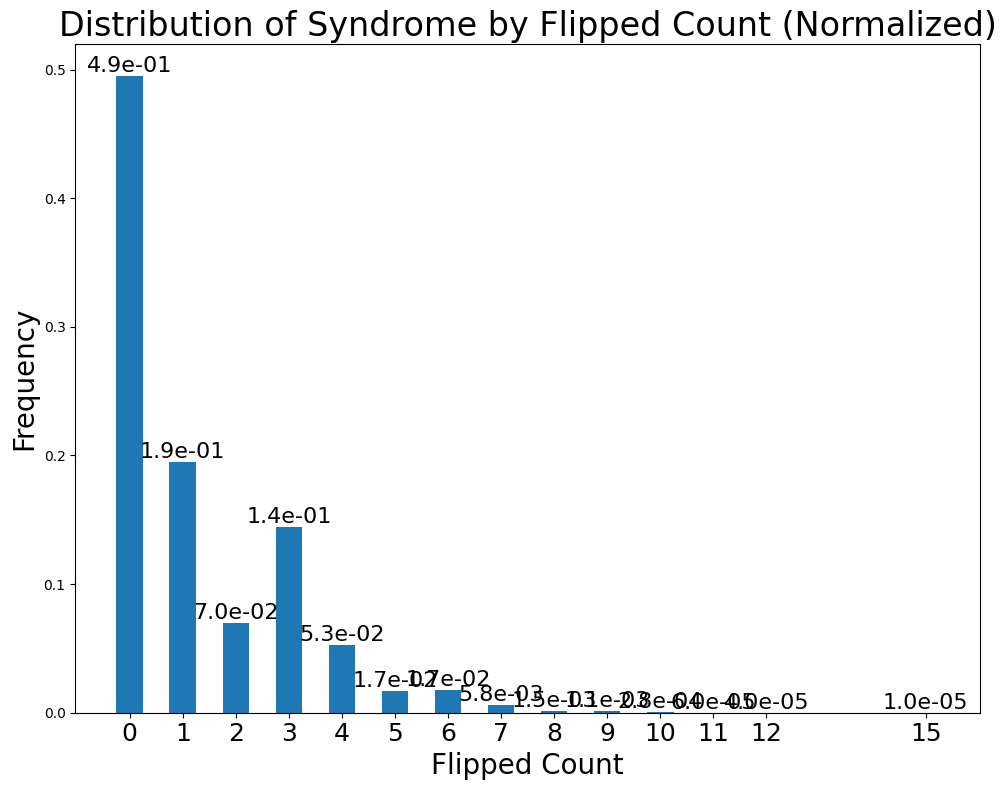

In [23]:
import matplotlib.pyplot as plt

true_counts = grouped_counts.index.values.get()
count_values = grouped_counts.iloc[:, -1].values.get()  # 假设counts在第一列

# 计算频率
total = count_values.sum()
frequency_values = count_values / total

# 创建图形
plt.figure(figsize=(10, 8))
# x_positions = true_counts * 1.5
# plt.bar(true_counts, frequency_values)  # 使用频率值而不是原始计数
bars = plt.bar(true_counts, frequency_values, width=0.5)  # 获取柱状图对象

# plt.xticks(x_positions, true_counts)  # 需要同时设置位置和标签

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1e}',  # 显示4位小数
             ha='center', va='bottom', fontsize=16)

# 添加标签和标题
plt.xlabel('Flipped Count', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Syndrome by Flipped Count (Normalized)', fontsize= 24)
plt.xticks(true_counts, fontsize=18)  # 确保x轴显示所有true_count值


plt.tight_layout()
# 显示图形
plt.show()

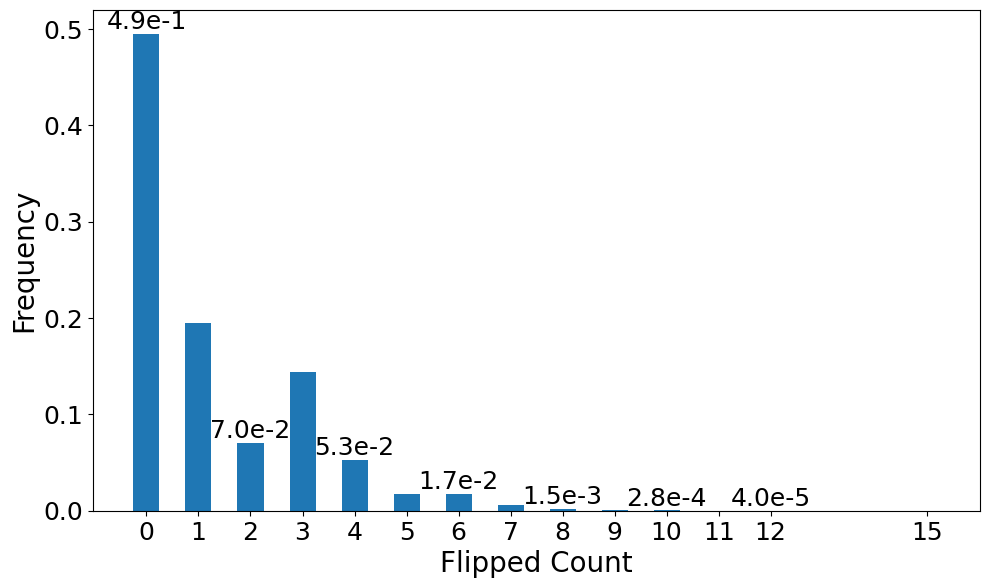

In [ ]:
def custom_scientific_notation(num):
    """自定义科学计数法格式化函数，让指数部分以一位数字显示"""
    s = "{:.1e}".format(num)
    mantissa, exponent = s.split("e")
    exponent = int(exponent)
    if exponent < 0:
        return f"{mantissa}e-{abs(exponent)}"
    return f"{mantissa}e+{exponent}"

# 对true_counts排序并获取排序后的索引
sorted_indices = sorted(range(len(true_counts)), key=lambda i: true_counts[i])

# 根据排序后的索引重新排列true_counts和frequency_values
true_counts = [true_counts[i] for i in sorted_indices]
frequency_values = [frequency_values[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
bars = plt.bar(true_counts, frequency_values, width=0.5)  # 获取柱状图对象

for i, bar in enumerate(bars):
    if i % 2 == 0:  # 每隔一个显示值
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 custom_scientific_notation(height),  # 显示4位小数
                 ha='center', va='bottom', fontsize=18)  # 设置柱状图上文本的字体大小

# 添加标签和标题
plt.xlabel('Flipped Count', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
# plt.title('Distribution of Syndrome by Flipped Count (Normalized)', fontsize=24)
plt.xticks(true_counts, fontsize=18)  # 确保x轴显示所有true_count值
plt.yticks(fontsize=18)  # 设置y轴刻度的字体大小

plt.tight_layout()
# 显示图形
# plt.show()

from pathlib import Path

# 保存图片为PDF
save_dir = Path("../experiment/eamld_paper_experiment/figure/introduction")
save_dir.mkdir(parents=True, exist_ok=True)
save_path = save_dir / "distribution_of_syndrome.pdf"
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches='tight')

plt.show()



In [ ]:
# sample = np.hstack((syndromes, actual_observables))
# len_syndrome = syndromes.shape[1]
# # 尝试使用 cudf 进行处理
# df_syndromes = cudf.DataFrame(syndromes)
# unique_counts_syndromes = df_syndromes.value_counts().reset_index()

# unique_syndromes = unique_counts_syndromes.iloc[:, :-1].to_numpy()
# # counts_syndromes = unique_counts.iloc[:, -1].to_numpy()
# # unique_syndrome = unique_sample[:, :len_syndrome]
# # unique_actual_observables = unique_sample[:, len_syndrome:]

# # 计算每个syndrome中True的数量
# true_counts = unique_counts_syndromes.iloc[:, :len_syndrome].sum(axis=1)

# # 将结果添加到DataFrame中
# unique_counts_syndromes['true_count'] = true_counts

# # 按true_count分组统计
# grouped_counts_syndromes = unique_counts_syndromes.groupby('true_count').sum()

# import matplotlib.pyplot as plt

# # 准备数据
# true_counts = grouped_counts_syndromes.index.values.get()
# count_values = grouped_counts_syndromes.iloc[:, -1].values.get()  # 假设counts在第一列

# # 创建图形
# plt.figure(figsize=(10, 6))
# plt.bar(true_counts, count_values)

# # 添加标签和标题
# plt.xlabel('True Count')
# plt.ylabel('Frequency')
# plt.title('Distribution of Syndrome Patterns by True Count')
# plt.xticks(true_counts)  # 确保x轴显示所有true_count值

# # 显示图形
# plt.show()

# 不同汉明权重的解码情况的分析

In [ ]:
from eamld.benchmark import generate_qldpc_detector_error_model, generate_qldpc_syndrome_and_observables
import cudf
import numpy as np

nkd = [72, 12, 6]
# nkd = [90, 8, 10]
# nkd = [144, 12, 12]
p = 10
r = 1
noise_model = "si1000" # v5
error_type = "Z"
approximatestrategy = "hyperedge_topk"
approximate_param = 10

related_path = "../data/external/eamld_experiment_data/paper_experiment_bb_codes"
dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

syndromes, actual_observables = generate_qldpc_syndrome_and_observables(nkd, r, p, noise_model, error_type, related_path)

In [2]:
import numpy as np
sample = np.hstack((syndromes, actual_observables))
len_syndrome = syndromes.shape[1]
# 尝试使用 cudf 进行处理
df = cudf.DataFrame(sample)
unique_counts = df.value_counts().reset_index()

unique_sample = unique_counts.iloc[:, :-1].to_numpy()
counts_sample = unique_counts.iloc[:, -1].to_numpy()

# 切割出syndrome和observables部分
unique_sample_syndrome = unique_sample[:, :len_syndrome]
unique_sample_actual_observables = unique_sample[:, len_syndrome:]

In [3]:
# 计算每个syndrome中True的数量
true_counts = unique_counts.iloc[:, :len_syndrome].sum(axis=1)

# 将结果添加到DataFrame中
unique_counts['true_count'] = true_counts

# 按true_count分组统计
grouped_counts = unique_counts.groupby('true_count').sum()

true_counts = grouped_counts.index.values.get()

In [4]:
# 计算每行的汉明权重（1的个数）
syndrome_hamming = np.sum(unique_sample_syndrome, axis=1)
observables_hamming = np.sum(unique_sample_actual_observables, axis=1)

hamming_weight_list = sorted(true_counts)
# hamming_weight_list

hamming_weight = 3
# 筛选汉明权重为2的行
mask = syndrome_hamming == hamming_weight
hamming_syndromes = unique_sample_syndrome[mask]
hamming_observables = unique_sample_actual_observables[mask]
hamming_counts = counts_sample[mask]

In [5]:
import numpy as np
def sample_decode(syndrome: np.ndarray, syndromes: np.ndarray, actual_observables: np.ndarray):
    # Find the indices where self.syndromes matches the input syndrome
    matching_indices = np.all(syndromes == syndrome, axis=1)
    
    # Get the corresponding actual observables for the matching syndromes
    matching_observables = actual_observables[matching_indices]
    
    # 统计相同的observables的数量
    df_observables = cudf.DataFrame(matching_observables)
    unique_counts_observables = df_observables.value_counts().reset_index()
    unique_observables = unique_counts_observables.iloc[:, :-1].to_numpy()
    counts_observables = unique_counts_observables.iloc[:, -1].to_numpy()
    # 获取最大的observables的数量
    max_count_observables = np.max(counts_observables)
    # 获取最大的observables
    max_observables = unique_observables[counts_observables == max_count_observables]
    
    # Calculate the ratio of True and False counts
    true_count = max_count_observables
    false_count = len(matching_observables) - true_count
    true_ratio = true_count / (true_count + false_count)
    
    # Return the result: the most likely value and its confidence ratio
    return np.array(max_observables), true_ratio
# syndrome = np.array([False] * (num_detectors))
# sample_decode(syndrome, syndromes, actual_observables)

In [ ]:
# import eamld
# nkd = [72, 12, 6]
# p = 10
# r = 1
# noise_model = "si1000" # v5
# error_type = "Z"
# approximatestrategy = "hyperedge_topk"
# approximate_param = 10

# related_path = "../data/external/eamld_experiment_data/paper_experiment_bb_codes"
# dem = generate_qldpc_detector_error_model(nkd=nkd, r=r, p=p, noise_model=noise_model, error_type=error_type, related_path=related_path)

# eamld_decoder = eamld.EAMLD(detector_error_model=dem,
#                             order_method='greedy',
#                             slice_method='no_slice',
#                             use_approx = True,
#                             approximatestrategy = approximatestrategy,
#                             approximate_param = approximate_param,
#                             contraction_code = "qldpc-hierarchical-first",
#                             accuracy = "float64")
# from stimbposd import BPOSD
# max_bp_iters = 100
# bp_osd_decoder  = BPOSD(dem, max_bp_iters = max_bp_iters)

# counts = 0
# error_eamld_syndrome_counts = 0
# # for hamming_weight in hamming_weight_list[3:4]:
# for hamming_weight in [13]:
#     mask = syndrome_hamming == hamming_weight
#     hamming_syndromes = unique_sample_syndrome[mask]
#     # hamming_observables = unique_sample_actual_observables[mask]
#     hamming_counts = counts_sample[mask]
#     print(f"hamming_weight is:{hamming_weight}")
#     for i in range(len(hamming_syndromes)):
#         syndrome = hamming_syndromes[i,:]
#         hamming_count = hamming_counts[i]
#         counts = counts + 1
#         pre_eamld = eamld_decoder.decode(syndrome)[0][0].astype(int)
#         pre_bp_osd = bp_osd_decoder.decode(syndrome)
#         pre_sample = sample_decode(syndrome, syndromes, actual_observables)[0][0].astype(int)

#         # print(f"pre_sample:{pre_sample}")
#         if np.any(pre_eamld != pre_bp_osd) or np.any(pre_eamld != pre_sample):
#             print(f"syndrome: {np.where(syndrome == True)}")
#             print(f"pre_eamld:{pre_eamld}")
#             print(f"pre_bp_osd:{pre_bp_osd}")
#             print(f"pre_sample:{pre_sample}")    
#             print(f"----------------------")
#             error_eamld_syndrome_counts = error_eamld_syndrome_counts + hamming_count
#             break
#         # if np.any(pre_sample != 0):
#             # print(f"syndrome: {np.where(syndrome == True)}")
#             # 
#     print("error", error_eamld_syndrome_counts)
#     print(f"all syndrome:{counts}")

近似权重为10，汉明权重为3：
```
hamming_weight is:0
pre_eamld and pre_sample 0
all syndrome:1
hamming_weight is:2
pre_eamld and pre_sample 0
all syndrome:37
hamming_weight is:3
syndrome: (array([ 1, 13, 25]),)
pre_eamld:[0 1 1 1 0 1 1 1 1 0 1 1]
pre_bp_osd:[0 1 0 0 0 0 0 0 1 1 1 1]
pre_sample:[0 1 1 0 0 1 1 1 1 1 0 0]
----------------------
syndrome: (array([31, 33, 35]),)
pre_eamld:[0 0 0 0 0 0 0 0 0 0 1 1]
pre_bp_osd:[0 0 0 0 0 0 0 1 1 1 1 1]
pre_sample:[0 0 0 0 0 0 0 0 0 0 1 1]
----------------------
syndrome: (array([46, 58, 70]),)
pre_eamld:[0 1 0 0 1 1 1 1 0 0 0 0]
pre_bp_osd:[0 1 1 0 1 0 0 0 1 1 1 0]
pre_sample:[0 1 0 1 1 1 1 0 0 0 0 1]
----------------------
syndrome: (array([55, 57, 59]),)
pre_eamld:[1 1 0 0 1 1 0 0 1 0 0 0]
pre_bp_osd:[0 1 0 1 0 0 0 0 1 1 1 1]
pre_sample:[1 1 0 0 1 1 0 0 1 0 0 0]
----------------------
pre_eamld and pre_sample 4
all syndrome:621
```
近似权重为100，汉明权重为3：

p为100的情况下，依旧为这些。

In [7]:
len(hamming_syndromes[0,:])

72